# Fingerprint exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nglview

from opencadd.databases.klifs import setup_remote
from kissim.encoding import Fingerprint

In [3]:
# if using a Jupyter notebook, include:
#%matplotlib inline
plt.style.use("seaborn")
REMOTE = setup_remote()

In [4]:
HERE = Path(_dh[-1])
RESULTS = HERE / "../../results/"

## Load fingerprints

In [5]:
with open(RESULTS / "fingerprints.json", "r") as f:
    json_string = f.read()
fingerprints = json.loads(json_string)
print(f"Number of fingerprints: {len(fingerprints)}")

Number of fingerprints: 4918


## Prepare feature data

- Get feature values for all fingerprints
- Get feature values for example fingerprint

In [6]:
def features_by_type(fingerprints, feature_type):
    try:
        features = [fingerprint["values_dict"][feature_type] for fingerprint in fingerprints]
    except KeyError:
        features = [fingerprint["values_dict"]["spatial"][feature_type] for fingerprint in fingerprints]
    
    if feature_type == "moments":
        f = []
        for i in features:
            for key, values in i.items():
                f.append(values)
        features = pd.DataFrame(f, columns=["moment1", "moment2", "moment3"])
    else: 
        features = pd.DataFrame(features)
        features = pd.concat([features[column_name].explode(column_name) for column_name, column in features.items()], axis=1)
    features = features.astype("float64")
    return features

In [7]:
def features_by_structure_klifs_id(fingerprints, structure_klifs_id):
    return [fingerprint for fingerprint in fingerprints if fingerprint["structure_klifs_id"] == 3835][0]

## Feature distributions

### Qualitative/categorial/discrete features

In [8]:
features = features_by_type(fingerprints, "physicochemical")
features

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure
0,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.708333
1,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.583333
2,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.307692
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.600000
4,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,0.833333
...,...,...,...,...,...,...,...,...
418025,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.542857
418026,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000
418027,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.565217
418028,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.578947


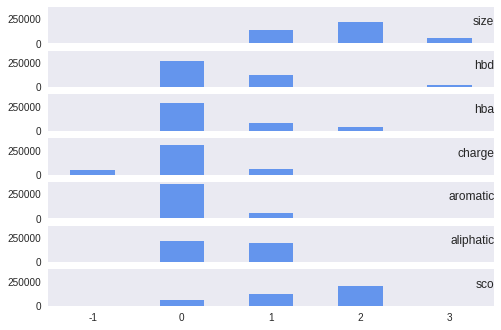

In [9]:
counts = pd.concat(
    [features[name].dropna().astype("int32").value_counts() for name, feature in features.items() if name != "exposure"],
    axis=1
)
counts = counts.fillna(0).astype("int32")
axes = counts.plot(kind="bar", subplots=True, grid=False, color="cornflowerblue", sharey=True, rot=0, legend=None, title=[""]*counts.shape[1])
[ax.set_title(name, loc="right", pad=0, y=0.5) for ax, name in zip(axes, counts.columns)];

### Continuous features

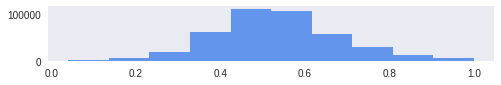

In [10]:
features["exposure"].hist(color="cornflowerblue", figsize=(8, 1), grid=False);

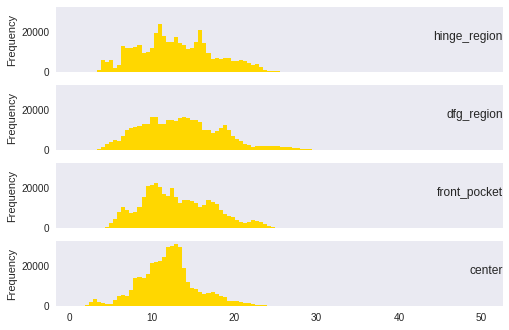

In [11]:
features = features_by_type(fingerprints, "distances")
axes = features.plot(kind="hist", subplots=True, grid=False, color="gold", sharey=True, rot=0, legend=None, title=[""]*features.shape[1], bins=100);
[ax.set_title(name, loc="right", pad=0, y=0.5) for ax, name in zip(axes, features.columns)];

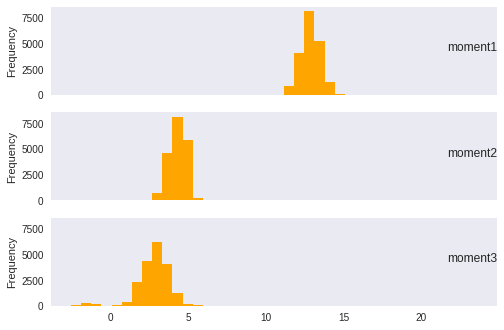

In [12]:
features = features_by_type(fingerprints, "moments")
axes = features.plot(kind="hist", subplots=True, grid=False, color="orange", sharey=True, rot=0, legend=None, title=[""]*features.shape[1], bins=40);
[ax.set_title(name, loc="right", pad=0, y=0.5) for ax, name in zip(axes, features.columns)];

## Example fingerprint in 3D

In [13]:
#fingerprint = features_by_structure_klifs_id(fingerprints, 3835)
example_fingerprint = Fingerprint.from_structure_klifs_id(3835)
example_features = example_fingerprint.physicochemical
example_features.index = example_fingerprint.residue_ids
example_features

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure
50,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.708333
51,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.583333
52,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.307692
53,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.600000
54,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,0.833333
...,...,...,...,...,...,...,...,...
194,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.538462
195,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.358974
196,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.555556
197,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.468750


### Side chain orientation

In [14]:
value_to_color = {0.0: "blue", 1.0: "magenta", 2.0: "red"}

color_scheme_list = []
for residue_id, value in example_features.iterrows():
    try:
        color = value_to_color[value["sco"] ]
    except KeyError:
        color = "grey"
    color_scheme_list.append([color, str(residue_id)])

In [18]:
viewer = nglview.NGLWidget()
viewer._remote_call("setSize", target="Widget", args=["1000px", "600px"])
text = REMOTE.coordinates.to_text(3835, "complex", "pdb")
viewer.add_component(text, ext="pdb")
viewer.clear_representations()
color_scheme = nglview.color._ColorScheme(color_scheme_list, label="scheme_regions")
viewer.add_representation(
    "cartoon",
    selection="protein",
    component=0,
    color="grey",
)
selection = " or ".join([str(i) for i in example_fingerprint.residue_ids])
viewer.add_representation("ball+stick", selection=selection, color=color_scheme)
viewer

NGLWidget()

In [19]:
viewer.render_image(trim=True, factor=2, transparent=True);

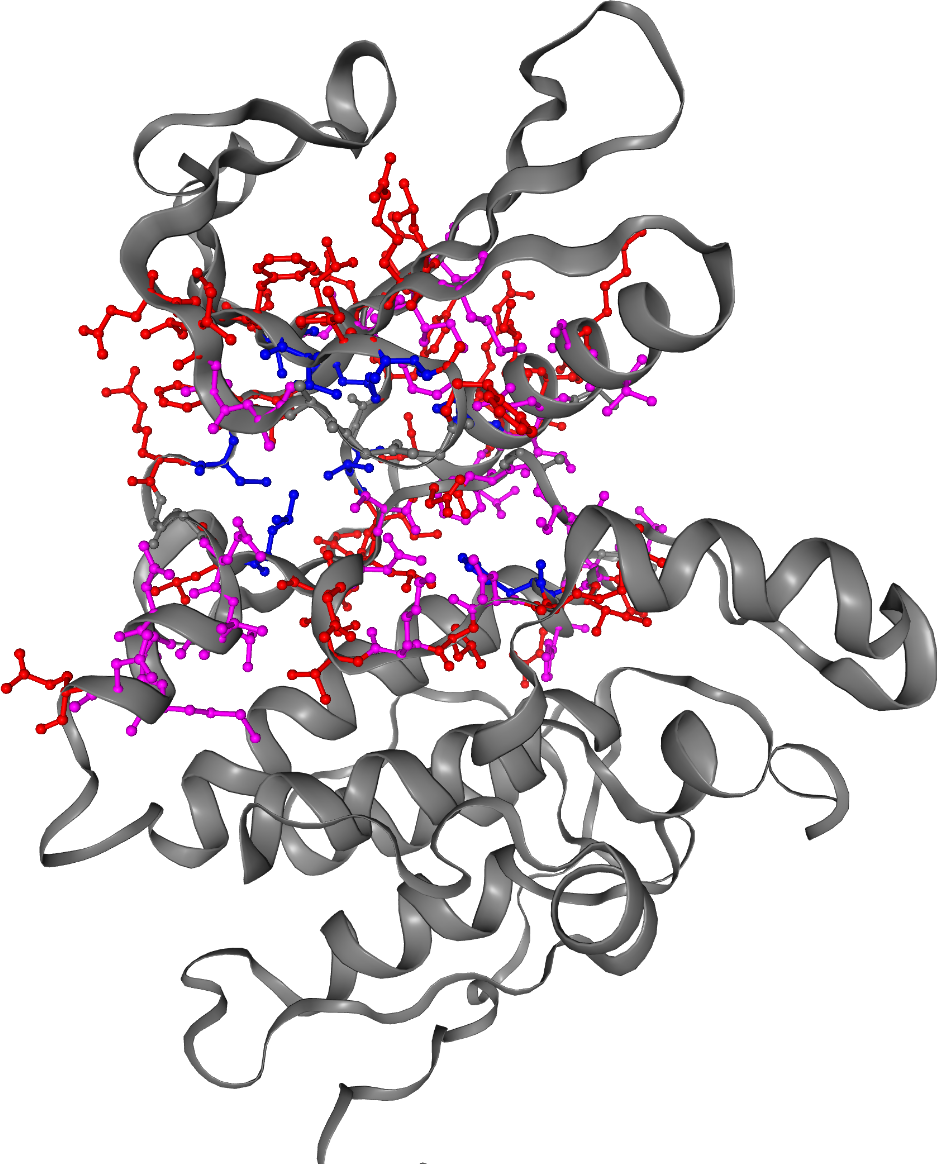

In [20]:
viewer._display_image()

__Relationship between side chain orientation of E24 and DFG conformation?__

In [34]:
sco_24e = [(fingerprint["structure_klifs_id"], fingerprint["values_dict"]["physicochemical"]["sco"][24-1]) for fingerprint in fingerprints]
sco_24e = pd.DataFrame(sco_24e, columns=["structure.klifs_id", "sco"])

In [36]:
structures = REMOTE.structures.all_structures()
structures = structures[structures["structure.klifs_id"].isin(sco_24e["structure.klifs_id"])]

In [37]:
pd.merge(sco_24e, structures, on="structure.klifs_id").groupby(["sco", "structure.dfg"]).size()

sco  structure.dfg
0.0  in               3046
     na                 43
     out               279
     out-like           56
1.0  in                764
     na                 41
     out               105
     out-like           71
2.0  in                366
     na                 10
     out                 8
     out-like           10
dtype: int64